#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

In [2]:
plt.rcParams["figure.figsize"] = (12,8)

In [3]:
df_train = pd.read_csv("data_used/df_train.csv")
df_test = pd.read_csv("data_used/df_test.csv")

#### Size of training and testing set

In [4]:
print("Training shape:", df_train.shape)
print("Testing shape::", df_test.shape)

Training shape: (702, 18)
Testing shape:: (176, 18)


In [5]:
df_train["HDD_capacity"].value_counts()

0.0          693
1.0            5
1024.0         3
5121024.0      1
Name: HDD_capacity, dtype: int64

Most laptops don't use HDD, so we remove this feature

In [6]:
df_train = df_train.drop("HDD_capacity", axis = 1)
df_test = df_test.drop("HDD_capacity", axis = 1)

Remove SSD_capacity > 8000 as these are outliers

In [7]:
df_train = df_train.drop(index = df_train[df_train["SSD_capacity"]>8000].index).reset_index(drop = True)

#### Handling missing values

In [8]:
ram_imputer = SimpleImputer(strategy='most_frequent')
df_train["ram_type"] = ram_imputer.fit_transform(df_train[["ram_type"]])
df_test["ram_type"] = ram_imputer.transform(df_test[["ram_type"]])

To impute the missing value for the type of ram, we simply replace the missing value by the most popular one

In [9]:
df_train["ram_type"].value_counts()

DDR4                 533
DDR5                  83
LPDDR5                46
LPDDR4x               21
LPDDR3                13
DDR3L                  1
LPDDR3L                1
DDR5-4800 SO-DIMM      1
LPDDDR5                1
Name: ram_type, dtype: int64

Normalize the type of ram

In [10]:
def normalize_ram(x):
    if x == "DDR5-4800 SO-DIMM":
        return "DDR5"
    elif x == "LPDDDR5":
        return "LPDDR5"
    elif x == "LPDDR3L" or x == "DDR3L":
        return "LPDDR3"
    else:
        return x

In [11]:
df_train["ram_type"] = df_train["ram_type"].apply(normalize_ram)
df_test["ram_type"] = df_test["ram_type"].apply(normalize_ram)

In [12]:
df_train["ram_type"].value_counts()

DDR4       533
DDR5        84
LPDDR5      47
LPDDR4x     21
LPDDR3      15
Name: ram_type, dtype: int64

In [13]:
df_train.columns

Index(['website', 'battery', 'weight', 'laptop_brand', 'monitor_size',
       'ram_capacity', 'ram_type', 'SSD_capacity', 'cpu_brand', 'cpu_core_num',
       'cpu_thread_num', 'avg_bench', 'gamming', 'desktop', 'workstation',
       'gpu_score', 'price'],
      dtype='object')

As the value 0 from the CPU benchmark show that the score is missing, we replace those by NA to avoid misleading the models

In [14]:
df_train["avg_bench"] = df_train["avg_bench"].replace(0, np.nan)
df_train["desktop"] = df_train["desktop"].replace(0, np.nan)
df_train["gamming"] = df_train["gamming"].replace(0, np.nan)
df_train["workstation"] = df_train["workstation"].replace(0, np.nan)
df_test["avg_bench"] = df_test["avg_bench"].replace(0, np.nan)
df_test["desktop"] = df_test["desktop"].replace(0, np.nan)
df_test["gamming"] = df_test["gamming"].replace(0, np.nan)
df_test["workstation"] = df_test["workstation"].replace(0, np.nan)
# df_train = df_train.drop(["desktop", "gamming", "workstation"], axis = 1)
# df_test = df_test.drop(["desktop", "gamming", "workstation"], axis = 1)


In [15]:
df_train.columns

Index(['website', 'battery', 'weight', 'laptop_brand', 'monitor_size',
       'ram_capacity', 'ram_type', 'SSD_capacity', 'cpu_brand', 'cpu_core_num',
       'cpu_thread_num', 'avg_bench', 'gamming', 'desktop', 'workstation',
       'gpu_score', 'price'],
      dtype='object')

In [16]:
df_train['laptop_brand'].value_counts()

Lenovo       146
Dell         143
Asus         134
HP            80
MSI           43
Acer          35
LG            31
GIGABYTE      20
Apple         15
Razer         11
Other         11
Samsung        9
Microsoft      9
Huawei         6
AVITA          4
Xiaomi         2
Colorful       1
Name: laptop_brand, dtype: int64

As the gpu score and cpu score might heavily affect the models, we add 2 columns to specify whether if the scores are missing 

In [17]:
def handle_unknown(x):
    if np.isnan(x) or x == 0:
        return 1
    else: 
        return 0

In [18]:
df_train["unknown_gpu"] = df_train["gpu_score"].apply(handle_unknown)
df_train["unknown_cpu"] = df_train["avg_bench"].apply(handle_unknown)
df_test["unknown_gpu"] = df_test["gpu_score"].apply(handle_unknown)
df_test["unknown_cpu"] = df_test["avg_bench"].apply(handle_unknown)

In [19]:
df_train.shape

(700, 19)

In [20]:
df_train.describe()

,battery,weight,monitor_size,ram_capacity,SSD_capacity,cpu_core_num,cpu_thread_num,avg_bench,gamming,desktop,workstation,gpu_score,price,unknown_gpu,unknown_cpu
count,568.000000,561.000000,698.000000,698.000000,700.000000,614.000000,605.000000,570.000000,570.000000,570.000000,570.000000,649.000000,7.000000e+02,700.000000,700.000000
mean,58.384085,1.625820,14.952722,12.618911,536.620000,7.140065,11.928926,73.434912,73.389474,78.085965,67.800000,94.157427,2.818080e+07,0.072857,0.185714
std,18.632861,0.510255,1.103990,7.409001,373.488505,3.431443,4.500542,15.137443,15.159929,13.412005,19.834783,44.932259,1.788864e+07,0.260088,0.389154
min,2.000000,0.736000,11.600000,4.000000,0.000000,2.000000,2.000000,17.600000,18.000000,20.000000,12.000000,1.430000,3.590000e+06,0.000000,0.000000
25%,45.000000,1.200000,14.000000,8.000000,256.000000,4.000000,8.000000,63.200000,63.000000,71.000000,52.000000,58.500000,1.699000e+07,0.000000,0.000000
50%,56.000000,1.600000,15.600000,8.000000,512.000000,6.000000,12.000000,72.400000,72.000000,78.000000,67.000000,112.000000,2.299000e+07,0.000000,0.000000
75%,71.000000,2.000000,15.600000,16.000000,512.000000,8.000000,16.000000,82.400000,82.000000,87.000000,77.000000,139.000000,3.299000e+07,0.000000,0.000000
max,100.000000,4.100000,17.300000,64.000000,5122.000000,16.000000,24.000000,114.000000,114.000000,114.000000,126.000000,154.000000,1.399900e+08,1.000000,1.000000


In [21]:
df_train.isnull().sum()

website             0
battery           132
weight            139
laptop_brand        0
monitor_size        2
ram_capacity        2
ram_type            0
SSD_capacity        0
cpu_brand           0
cpu_core_num       86
cpu_thread_num     95
avg_bench         130
gamming           130
desktop           130
workstation       130
gpu_score          51
price               0
unknown_gpu         0
unknown_cpu         0
dtype: int64

#### Handling numerical missing values

For the remaining missing numerical values, we use KNN to impute those unfilled values

In [22]:
imptr = KNNImputer()

In [23]:
numerical_cols = ["battery", 
          "weight", "monitor_size",
          "ram_capacity", 
          "SSD_capacity", 
          "cpu_core_num",
          "cpu_thread_num",
          "avg_bench", "desktop", "workstation" , "gamming",
          "gpu_score",
          "unknown_cpu",
          "unknown_gpu",
          "price"]
df1_train = df_train[numerical_cols]
df1_test = df_test[numerical_cols]

In [24]:
df2_train = pd.DataFrame(imptr.fit_transform(df1_train), columns = df1_train.columns)
df2_test = pd.DataFrame(imptr.transform(df1_test), columns = df1_test.columns)
df2_train

,battery,weight,monitor_size,ram_capacity,SSD_capacity,cpu_core_num,cpu_thread_num,avg_bench,desktop,workstation,gamming,gpu_score,unknown_cpu,unknown_gpu,price
0,62.0,1.430,14.0,16.0,512.0,6.0,12.0,76.80,81.0,72.0,77.0,121.00,0.0,0.0,23490000.0
1,50.0,1.000,14.0,8.0,512.0,12.0,16.0,94.80,97.0,94.0,95.0,139.00,0.0,0.0,19490000.0
2,80.0,2.500,16.0,32.0,1024.0,8.0,16.0,78.20,81.0,76.0,78.0,121.00,0.0,0.0,79990000.0
3,85.4,1.608,17.0,16.0,1024.0,12.0,20.0,114.00,114.0,126.0,114.0,139.00,0.0,0.0,45990000.0
4,56.5,1.000,14.0,16.0,512.0,9.6,14.4,74.52,79.4,70.2,74.4,112.94,1.0,1.0,22990000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,60.0,1.360,14.0,16.0,256.0,4.0,8.0,59.60,66.0,47.0,60.0,9.64,0.0,0.0,15990000.0
696,60.0,1.710,16.0,16.0,512.0,8.0,12.0,82.40,87.0,77.0,82.0,112.00,0.0,0.0,22990000.0
697,84.8,2.128,15.6,16.0,256.0,9.2,16.8,88.76,91.2,87.8,88.8,70.00,1.0,0.0,66990000.0
698,90.0,1.285,16.0,16.0,512.0,12.0,16.0,72.40,78.0,70.0,72.0,139.00,0.0,0.0,35990000.0


In [25]:
df_train[numerical_cols] = df2_train.values
df_test[numerical_cols] = df2_test.values

#### Transform categorical features into numerical ones

For the categorical features, as the number of features and the number of categories in each feature is not too large, we use one-hot encoding

In [26]:
# features_to_encode = ['website', 'cpu_brand','ram_type']
features_to_encode = ['website', 'cpu_brand','ram_type', 'laptop_brand']

In [27]:
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

In [28]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
train_enc = ohe.fit_transform(df_train[features_to_encode])

c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [29]:
df_train = pd.concat([df_train,pd.DataFrame(train_enc, columns=ohe.get_feature_names_out())], axis = 1)

In [30]:
test_enc = ohe.transform(df_test[features_to_encode])
#Converting back to a dataframe
df_test = pd.concat([df_test,pd.DataFrame(test_enc,columns=ohe.get_feature_names_out())], axis =1)

In [31]:
df_train = df_train.drop(features_to_encode, axis = 1)
df_test = df_test.drop(features_to_encode, axis = 1)
df_train = df_train.drop("website_laptop88", axis = 1)
df_test = df_test.drop("website_laptop88", axis = 1)

In [32]:
X_train = df_train.drop("price", axis = 1)
y_train = df_train["price"]
X_test = df_test.drop("price", axis = 1)
y_test = df_test["price"]

In [33]:
df_test

,battery,weight,monitor_size,ram_capacity,SSD_capacity,cpu_core_num,cpu_thread_num,avg_bench,gamming,desktop,...,laptop_brand_HP,laptop_brand_Huawei,laptop_brand_LG,laptop_brand_Lenovo,laptop_brand_MSI,laptop_brand_Microsoft,laptop_brand_Other,laptop_brand_Razer,laptop_brand_Samsung,laptop_brand_Xiaomi
0,65.0,2.100,15.60,16.0,256.0,6.0,12.0,70.10,70.0,74.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,64.8,1.746,15.14,4.0,512.0,4.0,8.0,66.00,66.0,74.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,80.0,2.000,16.00,16.0,512.0,14.0,20.0,98.10,98.0,100.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,57.5,2.200,15.60,8.0,512.0,6.0,12.0,74.50,74.0,78.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,42.0,1.664,15.60,8.0,512.0,8.0,16.0,72.30,72.0,74.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,70.0,2.000,16.00,8.0,512.0,8.0,12.8,71.98,71.8,76.6,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
172,45.0,2.250,15.60,8.0,256.0,6.0,12.0,73.00,73.0,76.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
173,65.0,2.380,15.60,16.0,512.0,8.0,16.0,87.90,88.0,90.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
174,54.0,1.950,16.00,16.0,512.0,8.8,13.2,73.80,74.0,80.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

Using Min-Max Scaling technique to scale the features

In [35]:
scaler = MinMaxScaler()

In [36]:
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = scaler.get_feature_names_out())
X_test = pd.DataFrame(scaler.transform(X_test), columns = scaler.get_feature_names_out())

In [40]:
from eval_baseline import eval_baseline

Here we calculate the importance of each feature using RandomForest, The following graph show how each feature contributes to the model

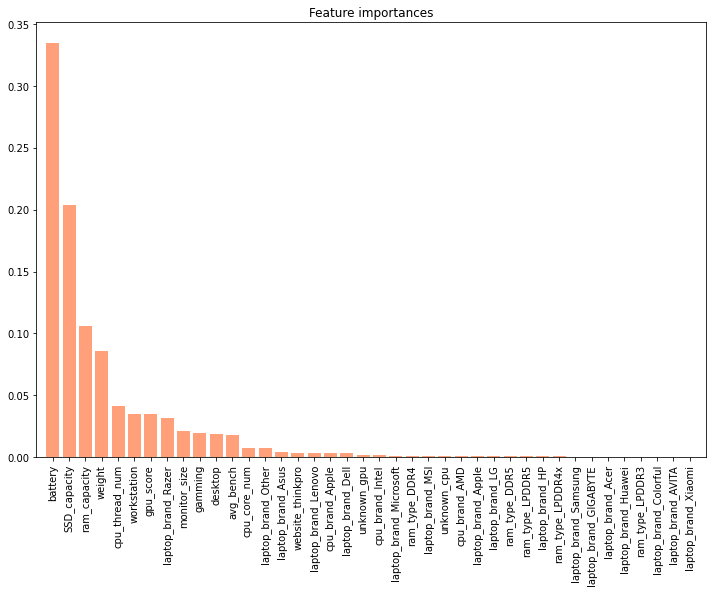

In [41]:
rf = RandomForestRegressor(n_estimators = 100, random_state=42)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="lightsalmon", align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

#### Feature selection 

Here, based on the feature importance retrieved from Random Forest, we take only the features with importance > 0.0025

In [42]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(rf, threshold=0.0025)
sfm.fit(X_train, y_train)
X_train = sfm.transform(X_train)
X_test = sfm.transform(X_test)
print("Number of features remaining: ", X_train.shape[1])

Number of features remaining:  19


In [43]:
eval_baseline(X_train, X_test, y_train, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished


0.7971783552280678

In [44]:
training_set = pd.concat([pd.DataFrame(X_train,columns = sfm.get_feature_names_out()), y_train.reset_index(drop=True)],axis = 1)
testing_set = pd.concat([pd.DataFrame(X_test,columns = sfm.get_feature_names_out()), y_test.reset_index(drop=True)], axis = 1)

In [45]:
training_set.to_csv('../data/training_set.csv')
testing_set.to_csv('../data/testing_set.csv')